In [36]:
# ============================================================================
# SETUP: Load data, define functions, create mappings
# ============================================================================
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

!pip install pyreadstat

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyreadstat

# Load error data
inflation_df, _ = pyreadstat.read_dta('/content/drive/MyDrive/FedComs/Indicators/inflation_errors.dta')
labor_df, _ = pyreadstat.read_dta('/content/drive/MyDrive/FedComs/Indicators/labor_errors.dta')

# Create merge keys for error data
inflation_df['ym'] = inflation_df['year'].astype(int).astype(str) + '-' + inflation_df['month'].astype(int).astype(str).str.zfill(2)
labor_df['ym'] = labor_df['year'].astype(int).astype(str) + '-' + labor_df['month'].astype(int).astype(str).str.zfill(2)

# Load Fed communications data (with all officials)
fed_combined = pd.read_csv('/content/drive/MyDrive/FedComs/SummaryStats/Combined_Dataset.csv')
fed_combined['date'] = pd.to_datetime(fed_combined['date'])
fed_combined['ym'] = fed_combined['date'].dt.strftime('%Y-%m')

# Merge with error data
error_cols_infl = [col for col in inflation_df.columns if 'error' in col]
error_cols_labor = [col for col in labor_df.columns if 'error' in col]

df = fed_combined.merge(inflation_df[['ym'] + error_cols_infl], on='ym', how='left', suffixes=('', '_infl'))
df = df.merge(labor_df[['ym'] + error_cols_labor], on='ym', how='left', suffixes=('', '_labor'))

print(f"✓ Data loaded and merged: {df.shape}")
print(f"  Communication types: {df['com_type'].unique()}")
print(f"  Date range: {df['date'].min()} to {df['date'].max()}")

# ============================================================================
#toggle to omit years
df = df[df['date'].dt.year != 2020]
#df = df[(df['date'].dt.year != 2020) & (df['date'].dt.year != 2021)]
# ============================================================================

# Define indicator mappings
labor_indicators = {
    'Employment': 'error_yEmp',
    'Unemployment': 'error_yU',
    'Participation': 'error_yLFPR',
    'Vacancies': 'error_yVacancies',
    'Wages': 'error_yWages',
    'Layoffs': 'error_yLayoffs',
    'Quits': 'error_yQuits',
    'Hiring': 'error_yHires'
}

labor_indicators_rel = {
    'Employment': 'error_diff_yEmp',
    'Unemployment': 'error_diff_yU',
    'Participation': 'error_diff_yLFPR',
    'Vacancies': 'error_diff_yVacancies',
    'Wages': 'error_diff_yWages',
    'Layoffs': 'error_diff_yLayoffs',
    'Quits': 'error_diff_yQuits',
    'Hiring': 'error_diff_yHires'
}

inflation_indicators = {
    'Core': 'error_yCore',
    'Headline': 'error_yHeadline',
    'PCE': 'error_yPCE',
    'CPI': 'error_yCPI',
    'Services': 'error_yServices',
    'Goods': 'error_yGoods',
    'Housing': 'error_yHousing',
    'Wage_Inflation': 'error_yWages',
    'Energy': 'error_yCommodities'
}

inflation_indicators_rel = {
    'Core': 'error_diff_yCore',
    'Headline': 'error_diff_yHeadline',
    'PCE': 'error_diff_yPCE',
    'CPI': 'error_diff_yCPI',
    'Services': 'error_diff_yServices',
    'Goods': 'error_diff_yGoods',
    'Housing': 'error_diff_yHousing',
    'Wage_Inflation': 'error_diff_yWages',
    'Energy': 'error_diff_yCommodities'
}

# ============================================================================
#Clean Stata missing values ('.' → NaN) and convert to float
# ============================================================================

# Find all columns that came from the .dta files (the forecast errors)
error_columns = [col for col in df.columns if col.startswith('error_')]

for col in error_columns:
    # Method 1: Replace '.' and empty strings with NaN, then convert
    df[col] = df[col].replace(['.', ''], np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')  # 'coerce' turns remaining bad values → NaN

# Also fix emphasis columns just to be safe (sometimes saved as strings in CSV)
emphasis_columns = [col for col in df.columns if 'emphasis_' in col]
for col in emphasis_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"Cleaned {len(error_columns)} error columns and {len(emphasis_columns)} emphasis columns.")
print("Data types after cleaning:")
print(df[error_columns + emphasis_columns].dtypes)


# Define CLR transform function
def clr_transform(composition):
    """Apply Centered Log-Ratio transformation"""
    composition = np.array(composition)
    composition = np.where(composition == 0, 1e-10, composition)
    geo_mean = np.exp(np.mean(np.log(composition), axis=1, keepdims=True))
    clr_data = np.log(composition / geo_mean)
    return clr_data



Mounted at /content/drive
✓ Data loaded and merged: (4277, 140)
  Communication types: ['minutes' 'transcripts' 'statements' 'speeches' 'presscon']
  Date range: 2000-02-02 00:00:00 to 2025-09-23 00:00:00
Cleaned 35 error columns and 23 emphasis columns.
Data types after cleaning:
error_yCore                                  float64
error_yHeadline                              float64
error_yPCE                                   float64
error_yCPI                                   float64
error_yCommodities                           float64
error_yGoods                                 float64
error_yServices                              float64
error_yHousing                               float64
error_yWages                                 float64
error_PCE_core_only                          float64
error_diff_yCore                             float64
error_diff_yHeadline                         float64
error_diff_yPCE                              float64
error_diff_yCPI              

In [37]:
# ============================================================================
# Explore Indicator data
# ============================================================================

# Let's first understand what we're working with
print("Labor DataFrame:")
print("=" * 60)
print(f"Shape: {labor_df.shape}")
print(f"\nColumns with 'error': {[col for col in labor_df.columns if 'error' in col]}")
print(f"\nFirst few rows:")
print(labor_df[['year', 'month', 'ym', 'error_yU', 'error_yEmp']].head())

print("\n\nInflation DataFrame:")
print("=" * 60)
print(f"Shape: {inflation_df.shape}")
print(f"\nColumns with 'error': {[col for col in inflation_df.columns if 'error' in col]}")
print(f"\nFirst few rows:")
print(inflation_df[['year', 'month', 'ym', 'error_yCore', 'error_yHeadline']].head())

# Check date ranges
print("\n\nDate Ranges:")
print("=" * 60)
print(f"Labor data: {labor_df['ym'].min()} to {labor_df['ym'].max()}")
print(f"Inflation data: {inflation_df['ym'].min()} to {inflation_df['ym'].max()}")

Labor DataFrame:
Shape: (300, 40)

Columns with 'error': ['error_yEmp', 'error_yVacancies', 'error_yU', 'error_yLFPR', 'error_yLayoffs', 'error_yQuits', 'error_yHires', 'error_yWages', 'abs_error_unrate_only', 'abs_error_yEmp', 'error_diff_yEmp', 'abs_error_yVacancies', 'error_diff_yVacancies', 'abs_error_yU', 'error_diff_yU', 'abs_error_yLFPR', 'error_diff_yLFPR', 'abs_error_yLayoffs', 'error_diff_yLayoffs', 'abs_error_yQuits', 'error_diff_yQuits', 'abs_error_yHires', 'error_diff_yHires', 'abs_error_yWages', 'error_diff_yWages']

First few rows:
     year  month       ym  error_yU  error_yEmp
0  2000.0    5.0  2000-05 -0.027123   -0.050439
1  2000.0    6.0  2000-06 -0.399870   -0.385664
2  2000.0    7.0  2000-07 -0.313157   -0.539338
3  2000.0    8.0  2000-08 -0.316360   -0.601167
4  2000.0    9.0  2000-09 -0.401053   -0.667729


Inflation DataFrame:
Shape: (355, 45)

Columns with 'error': ['error_yCore', 'error_yHeadline', 'error_yPCE', 'error_yCPI', 'error_yCommodities', 'error_yGoo

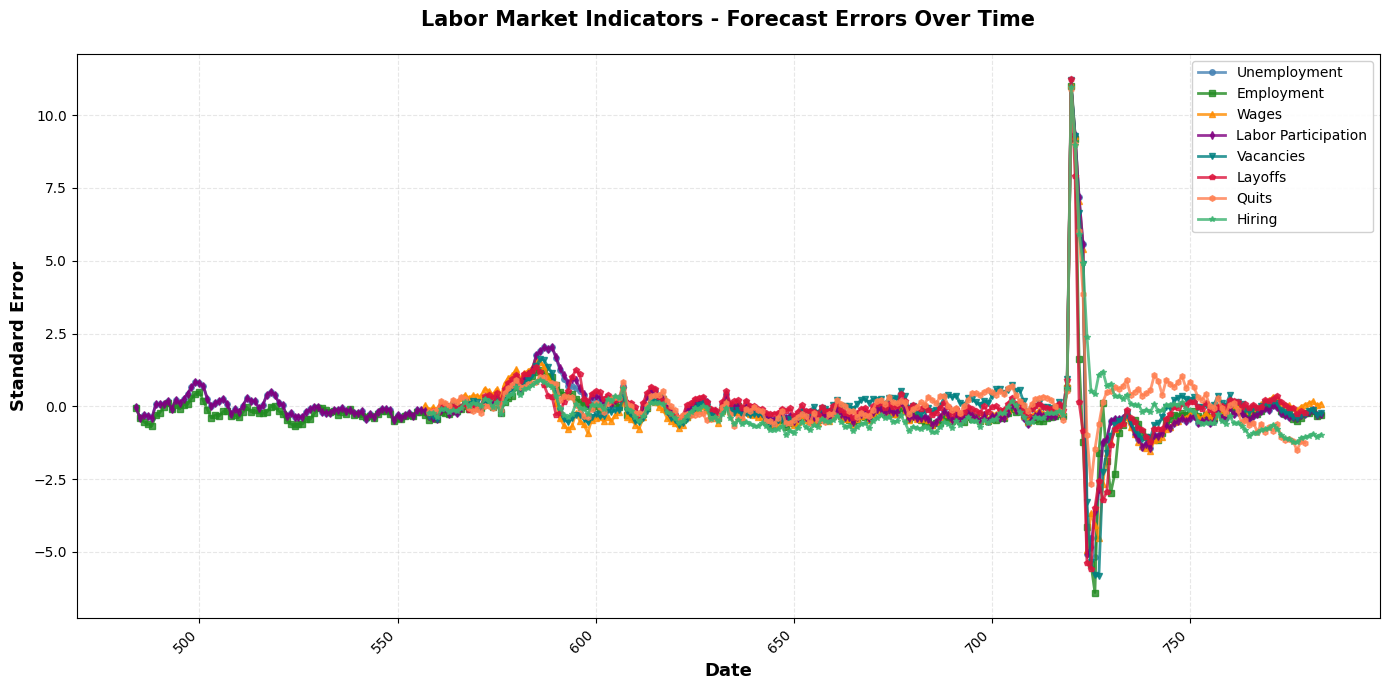

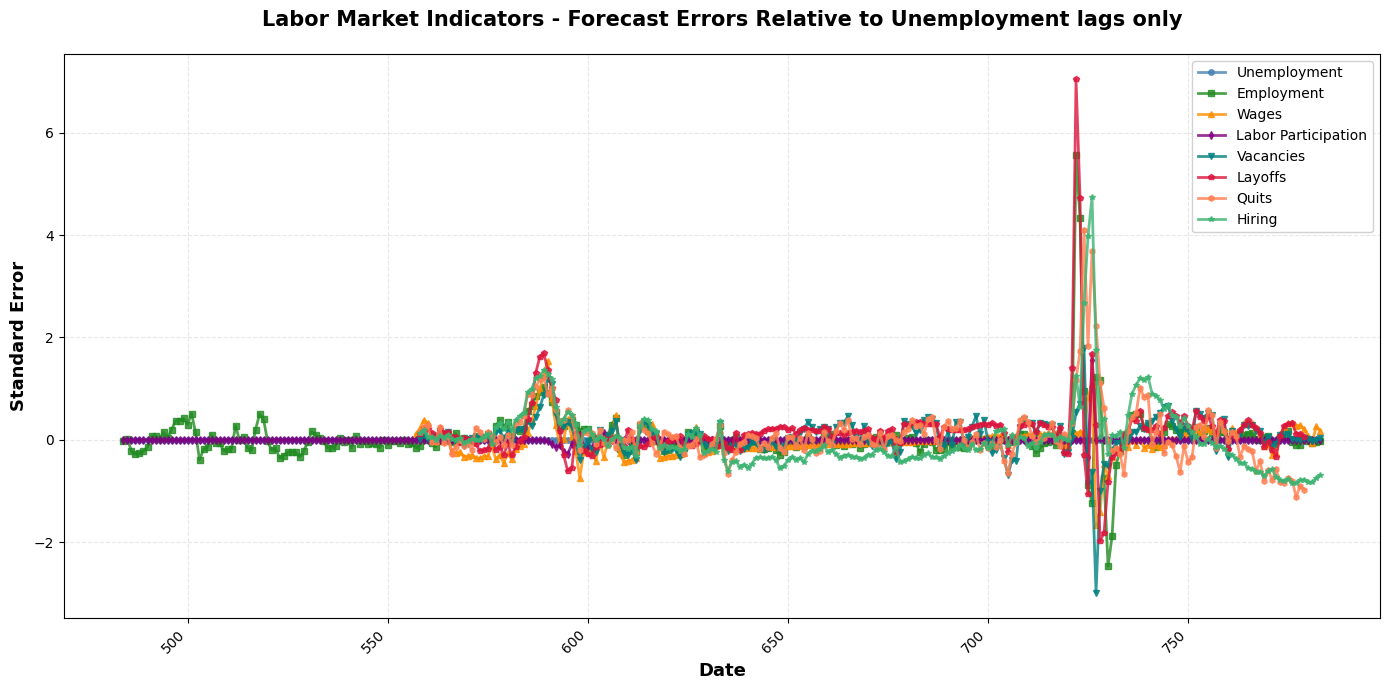

In [38]:
# ============================================================================
# CELL 6: Multiple Labor Indicators on One Plot
# ============================================================================

# Now let's plot several labor indicators together to compare them

fig, ax = plt.subplots(figsize=(14, 7))

# Define colors and markers for different indicators
plot_configs = {
    'error_yU': {'color': 'steelblue', 'marker': 'o', 'label': 'Unemployment'},
    'error_yEmp': {'color': 'forestgreen', 'marker': 's', 'label': 'Employment'},
    'error_yWages': {'color': 'darkorange', 'marker': '^', 'label': 'Wages'},
    'error_yLFPR': {'color': 'purple', 'marker': 'd', 'label': 'Labor Participation'},
    'error_yVacancies': {'color': 'teal', 'marker': 'v', 'label': 'Vacancies'},
    'error_yLayoffs': {'color': 'crimson', 'marker': 'p', 'label': 'Layoffs'},
    'error_yQuits': {'color': 'coral', 'marker': 'h', 'label': 'Quits'},
    'error_yHires': {'color': 'mediumseagreen', 'marker': '*', 'label': 'Hiring'}
}

# Plot each indicator
for col, config in plot_configs.items():
    if col in labor_df.columns:  # Check if column exists
        ax.plot(labor_df['date'],
                labor_df[col],
                color=config['color'],
                linewidth=2,
                marker=config['marker'],
                markersize=4,
                label=config['label'],
                alpha=0.8)  # Slight transparency

# Customize
ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Standard Error', fontsize=13, fontweight='bold')
ax.set_title('Labor Market Indicators - Forecast Errors Over Time',
             fontsize=15, fontweight='bold', pad=20)

# Grid and legend
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=10, loc='best', framealpha=0.9)  # framealpha makes legend background slightly transparent

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#-----------RELATIVE ERROR

fig, ax = plt.subplots(figsize=(14, 7))

# Define colors and markers for different indicators
plot_configs = {
    'error_diff_yU': {'color': 'steelblue', 'marker': 'o', 'label': 'Unemployment'},
    'error_diff_yEmp': {'color': 'forestgreen', 'marker': 's', 'label': 'Employment'},
    'error_diff_yWages': {'color': 'darkorange', 'marker': '^', 'label': 'Wages'},
    'error_diff_yLFPR': {'color': 'purple', 'marker': 'd', 'label': 'Labor Participation'},
    'error_diff_yVacancies': {'color': 'teal', 'marker': 'v', 'label': 'Vacancies'},
    'error_diff_yLayoffs': {'color': 'crimson', 'marker': 'p', 'label': 'Layoffs'},
    'error_diff_yQuits': {'color': 'coral', 'marker': 'h', 'label': 'Quits'},
    'error_diff_yHires': {'color': 'mediumseagreen', 'marker': '*', 'label': 'Hiring'}
}

# Plot each indicator
for col, config in plot_configs.items():
    if col in labor_df.columns:  # Check if column exists
        ax.plot(labor_df['date'],
                labor_df[col],
                color=config['color'],
                linewidth=2,
                marker=config['marker'],
                markersize=4,
                label=config['label'],
                alpha=0.8)  # Slight transparency

# Customize
ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Standard Error', fontsize=13, fontweight='bold')
ax.set_title('Labor Market Indicators - Forecast Errors Relative to Unemployment lags only',
             fontsize=15, fontweight='bold', pad=20)

# Grid and legend
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=10, loc='best', framealpha=0.9)  # framealpha makes legend background slightly transparent

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




In [39]:
# ============================================================================
# CELL 1: Helper Functions (adapted from comprehensive_analysis.py)
# ============================================================================

from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

def clr_transform(x):
    """
    Centered log-ratio (CLR) transformation
    CLR(x) = log(x) - mean(log(x))
    Handles zeros by adding a small constant
    """
    x = np.array(x, dtype=float)
    x = x + 1e-10  # Add small constant to avoid log(0)
    log_x = np.log(x)
    return log_x - np.mean(log_x)

def calculate_weighted_squared_error(emphasis_cols, error_cols, data):
    """
    Calculate emphasis-weighted squared error: Σ(emphasis_i × error_i²) / Σ(emphasis_i)
    Now safely converts to float and skips bad rows.
    """
    total_weighted_sq_error = 0.0
    total_emphasis = 0.0

    for emph_col, err_col in zip(emphasis_cols, error_cols):
        if emph_col not in data.columns or err_col not in data.columns:
            continue

        # Extract and clean both series
        emph_series = pd.to_numeric(data[emph_col], errors='coerce')
        err_series  = pd.to_numeric(data[err_col],  errors='coerce')

        # Combined mask for valid (non-NaN) pairs
        mask = emph_series.notna() & err_series.notna() & (emph_series >= 0)  # emphasis can't be negative

        if mask.sum() == 0:
            continue

        emphasis = emph_series[mask].values.astype(float)   # now guaranteed float64
        errors   = err_series[mask].values.astype(float)

        weighted_sq_error = np.sum(emphasis * np.abs(errors))
        total_weighted_sq_error += weighted_sq_error
        total_emphasis += np.sum(emphasis)

    return total_weighted_sq_error / total_emphasis if total_emphasis > 0 else np.nan

def calculate_clr_correlation(emphasis_cols, error_cols, data):
    """
    Calculate CLR correlation:
    1. CLR-transform both emphasis and squared errors
    2. Correlate component-wise
    3. Average the correlations
    """
    correlations = []

    for emph_col, err_col in zip(emphasis_cols, error_cols):
        if emph_col in data.columns and err_col in data.columns:
            mask = data[emph_col].notna() & data[err_col].notna()
            if mask.sum() > 2:  # Need at least 3 points for correlation
                emphasis = data.loc[mask, emph_col].values
                errors = data.loc[mask, err_col].values

                clr_emphasis = clr_transform(emphasis)
                clr_sq_errors = clr_transform(errors**2)

                if len(clr_emphasis) > 1 and np.std(clr_emphasis) > 0 and np.std(clr_sq_errors) > 0:
                    corr = np.corrcoef(clr_emphasis, clr_sq_errors)[0, 1]
                    if not np.isnan(corr):
                        correlations.append(corr)

    if correlations:
        return np.mean(correlations)
    else:
        return np.nan

print("✓ Helper functions defined")

✓ Helper functions defined


ANALYSIS 1: BY COMMUNICATION TYPE

Processing Labor Data by Communication Type...

  statements... n=190, WSE=0.373432, CLR=0.112779

  minutes... n=191, WSE=0.316020, CLR=0.062521

  presscon... n=154, WSE=0.301921, CLR=0.033908

  speeches... n=1068, WSE=0.281246, CLR=0.016634

  transcripts... n=2589, WSE=0.275176, CLR=0.019067

Processing Inflation Data by Communication Type...

  statements... n=190, WSE=0.007344, CLR=-0.046079

  minutes... n=191, WSE=0.007186, CLR=0.054829

  presscon... n=154, WSE=0.007350, CLR=0.014557

  speeches... n=1068, WSE=0.006845, CLR=-0.011814

  transcripts... n=2589, WSE=0.006485, CLR=0.010114

CREATING BAR GRAPHS

✓ Saved: analysis_1_communication_type.png


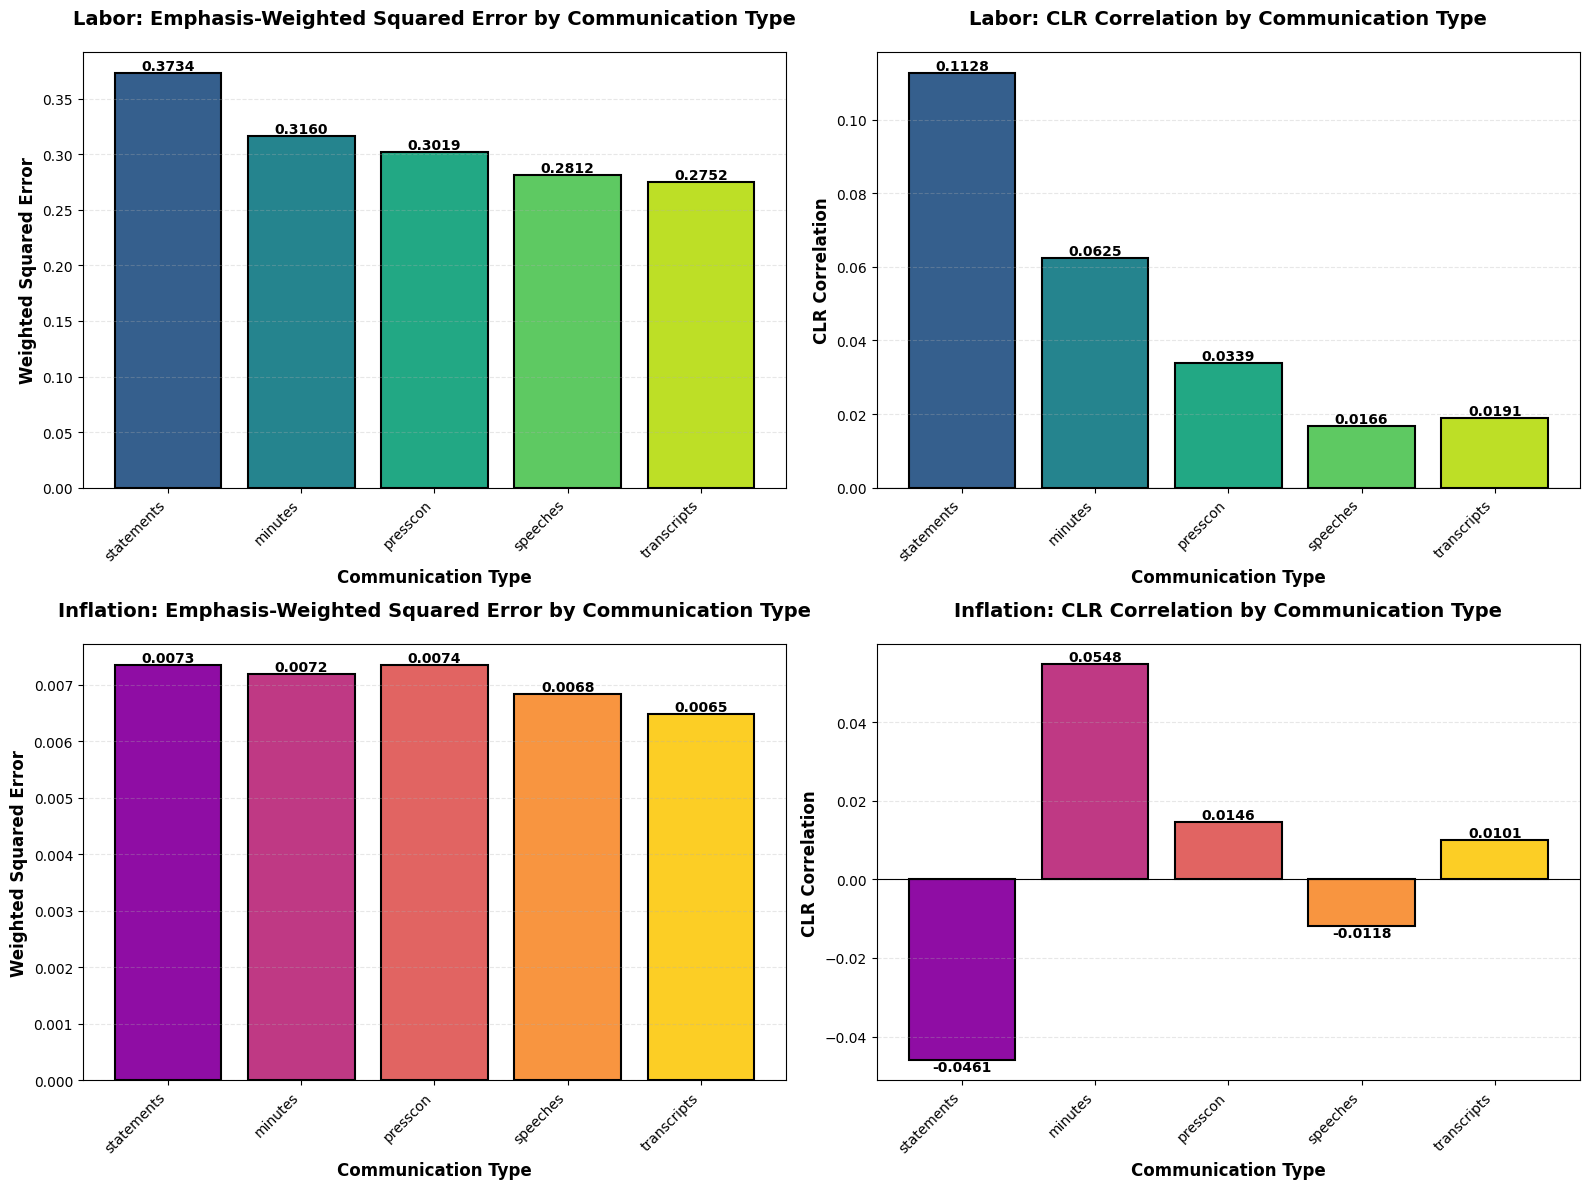


SUMMARY TABLE

LABOR:
Communication Type   WSE             CLR Correlation
--------------------------------------------------
statements                 0.373432       0.112779
minutes                    0.316020       0.062521
presscon                   0.301921       0.033908
speeches                   0.281246       0.016634
transcripts                0.275176       0.019067

INFLATION:
Communication Type   WSE             CLR Correlation
--------------------------------------------------
statements                 0.007344      -0.046079
minutes                    0.007186       0.054829
presscon                   0.007350       0.014557
speeches                   0.006845      -0.011814
transcripts                0.006485       0.010114

✓ ANALYSIS 1 COMPLETE


In [40]:
# ============================================================================
# CELL 2: ANALYSIS 1 - By Communication Type
# ============================================================================

print("="*80)
print("ANALYSIS 1: BY COMMUNICATION TYPE")
print("="*80)

# Communication types in order
com_types = ['statements', 'minutes', 'presscon', 'speeches', 'transcripts']

# Initialize results dictionaries
results_labor_wse = {}
results_labor_clr = {}
results_inflation_wse = {}
results_inflation_clr = {}

# LABOR ANALYSIS
print("\n" + "="*50)
print("Processing Labor Data by Communication Type...")
print("="*50)

for com_type in com_types:
    print(f"\n  {com_type}...", end=' ')
    data = df[df['com_type'] == com_type].copy()

    if len(data) > 0:
        # Get emphasis and error column pairs for labor
        emphasis_cols = [f'labor_emphasis_{ind}' for ind in labor_indicators.keys()
                        if f'labor_emphasis_{ind}' in data.columns]
        error_cols = [labor_indicators[ind] for ind in labor_indicators.keys()
                     if labor_indicators[ind] in data.columns]

        # Calculate metrics
        wse = calculate_weighted_squared_error(emphasis_cols, error_cols, data)
        clr_corr = calculate_clr_correlation(emphasis_cols, error_cols, data)

        results_labor_wse[com_type] = wse
        results_labor_clr[com_type] = clr_corr
        print(f"n={len(data)}, WSE={wse:.6f}, CLR={clr_corr:.6f}")
    else:
        results_labor_wse[com_type] = np.nan
        results_labor_clr[com_type] = np.nan
        print("No data")

# INFLATION ANALYSIS
print("\n" + "="*50)
print("Processing Inflation Data by Communication Type...")
print("="*50)

for com_type in com_types:
    print(f"\n  {com_type}...", end=' ')
    data = df[df['com_type'] == com_type].copy()

    if len(data) > 0:
        # Get emphasis and error column pairs for inflation
        emphasis_cols = [f'inflation_emphasis_{ind}' for ind in inflation_indicators.keys()
                        if f'inflation_emphasis_{ind}' in data.columns]
        error_cols = [inflation_indicators[ind] for ind in inflation_indicators.keys()
                     if inflation_indicators[ind] in data.columns]

        # Calculate metrics
        wse = calculate_weighted_squared_error(emphasis_cols, error_cols, data)
        clr_corr = calculate_clr_correlation(emphasis_cols, error_cols, data)

        results_inflation_wse[com_type] = wse
        results_inflation_clr[com_type] = clr_corr
        print(f"n={len(data)}, WSE={wse:.6f}, CLR={clr_corr:.6f}")
    else:
        results_inflation_wse[com_type] = np.nan
        results_inflation_clr[com_type] = np.nan
        print("No data")

# CREATE VISUALIZATIONS
print("\n" + "="*80)
print("CREATING BAR GRAPHS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Labor - Weighted Squared Error
ax = axes[0, 0]
x_pos = np.arange(len(com_types))
values = [results_labor_wse[ct] for ct in com_types]
colors_plot = plt.cm.viridis(np.linspace(0.3, 0.9, len(com_types)))
bars = ax.bar(x_pos, values, color=colors_plot, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Communication Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Weighted Squared Error', fontsize=12, fontweight='bold')
ax.set_title('Labor: Emphasis-Weighted Squared Error by Communication Type',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(com_types, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
for bar, val in zip(bars, values):
    if not np.isnan(val):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Labor - CLR Correlation
ax = axes[0, 1]
values = [results_labor_clr[ct] for ct in com_types]
bars = ax.bar(x_pos, values, color=colors_plot, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Communication Type', fontsize=12, fontweight='bold')
ax.set_ylabel('CLR Correlation', fontsize=12, fontweight='bold')
ax.set_title('Labor: CLR Correlation by Communication Type',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(com_types, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
for bar, val in zip(bars, values):
    if not np.isnan(val):
        va = 'bottom' if val >= 0 else 'top'
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{val:.4f}', ha='center', va=va, fontsize=10, fontweight='bold')

# Plot 3: Inflation - Weighted Squared Error
ax = axes[1, 0]
values = [results_inflation_wse[ct] for ct in com_types]
colors_plot = plt.cm.plasma(np.linspace(0.3, 0.9, len(com_types)))
bars = ax.bar(x_pos, values, color=colors_plot, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Communication Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Weighted Squared Error', fontsize=12, fontweight='bold')
ax.set_title('Inflation: Emphasis-Weighted Squared Error by Communication Type',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(com_types, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
for bar, val in zip(bars, values):
    if not np.isnan(val):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 4: Inflation - CLR Correlation
ax = axes[1, 1]
values = [results_inflation_clr[ct] for ct in com_types]
bars = ax.bar(x_pos, values, color=colors_plot, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Communication Type', fontsize=12, fontweight='bold')
ax.set_ylabel('CLR Correlation', fontsize=12, fontweight='bold')
ax.set_title('Inflation: CLR Correlation by Communication Type',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(com_types, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
for bar, val in zip(bars, values):
    if not np.isnan(val):
        va = 'bottom' if val >= 0 else 'top'
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{val:.4f}', ha='center', va=va, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('analysis_1_communication_type.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: analysis_1_communication_type.png")
plt.show()

# PRINT SUMMARY TABLE
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
print("\nLABOR:")
print(f"{'Communication Type':<20} {'WSE':<15} {'CLR Correlation':<15}")
print("-" * 50)
for ct in com_types:
    print(f"{ct:<20} {results_labor_wse[ct]:>14.6f} {results_labor_clr[ct]:>14.6f}")

print("\nINFLATION:")
print(f"{'Communication Type':<20} {'WSE':<15} {'CLR Correlation':<15}")
print("-" * 50)
for ct in com_types:
    print(f"{ct:<20} {results_inflation_wse[ct]:>14.6f} {results_inflation_clr[ct]:>14.6f}")

print("\n✓ ANALYSIS 1 COMPLETE")

ANALYSIS 2: BY OFFICIAL (TRANSCRIPTS & SPEECHES ONLY)

Filtered data: 3657 rows (transcripts + speeches)
Communication types: {'transcripts': 2589, 'speeches': 1068}

Unique speakers: 59

Role distribution:
role
Regional President    1771
Governor              1501
Chair                  384
.                        1
Name: count, dtype: int64

CALCULATING MEASURES FOR EACH OFFICIAL - LABOR

✓ Calculated measures for 61 officials (labor)
      speaker                role   last_name  n_transcripts  n_speeches  \
0   abroaddus  Regional President   abroaddus             36           0   
1  agreenspan               Chair  agreenspan             50           0   
2     akugler            Governor     akugler              0          25   
3  asantomero  Regional President  asantomero             46           0   
4   bbernanke               Chair   bbernanke             64         120   
5      cevans  Regional President      cevans             99           0   
6    cplosser  Regional Pr

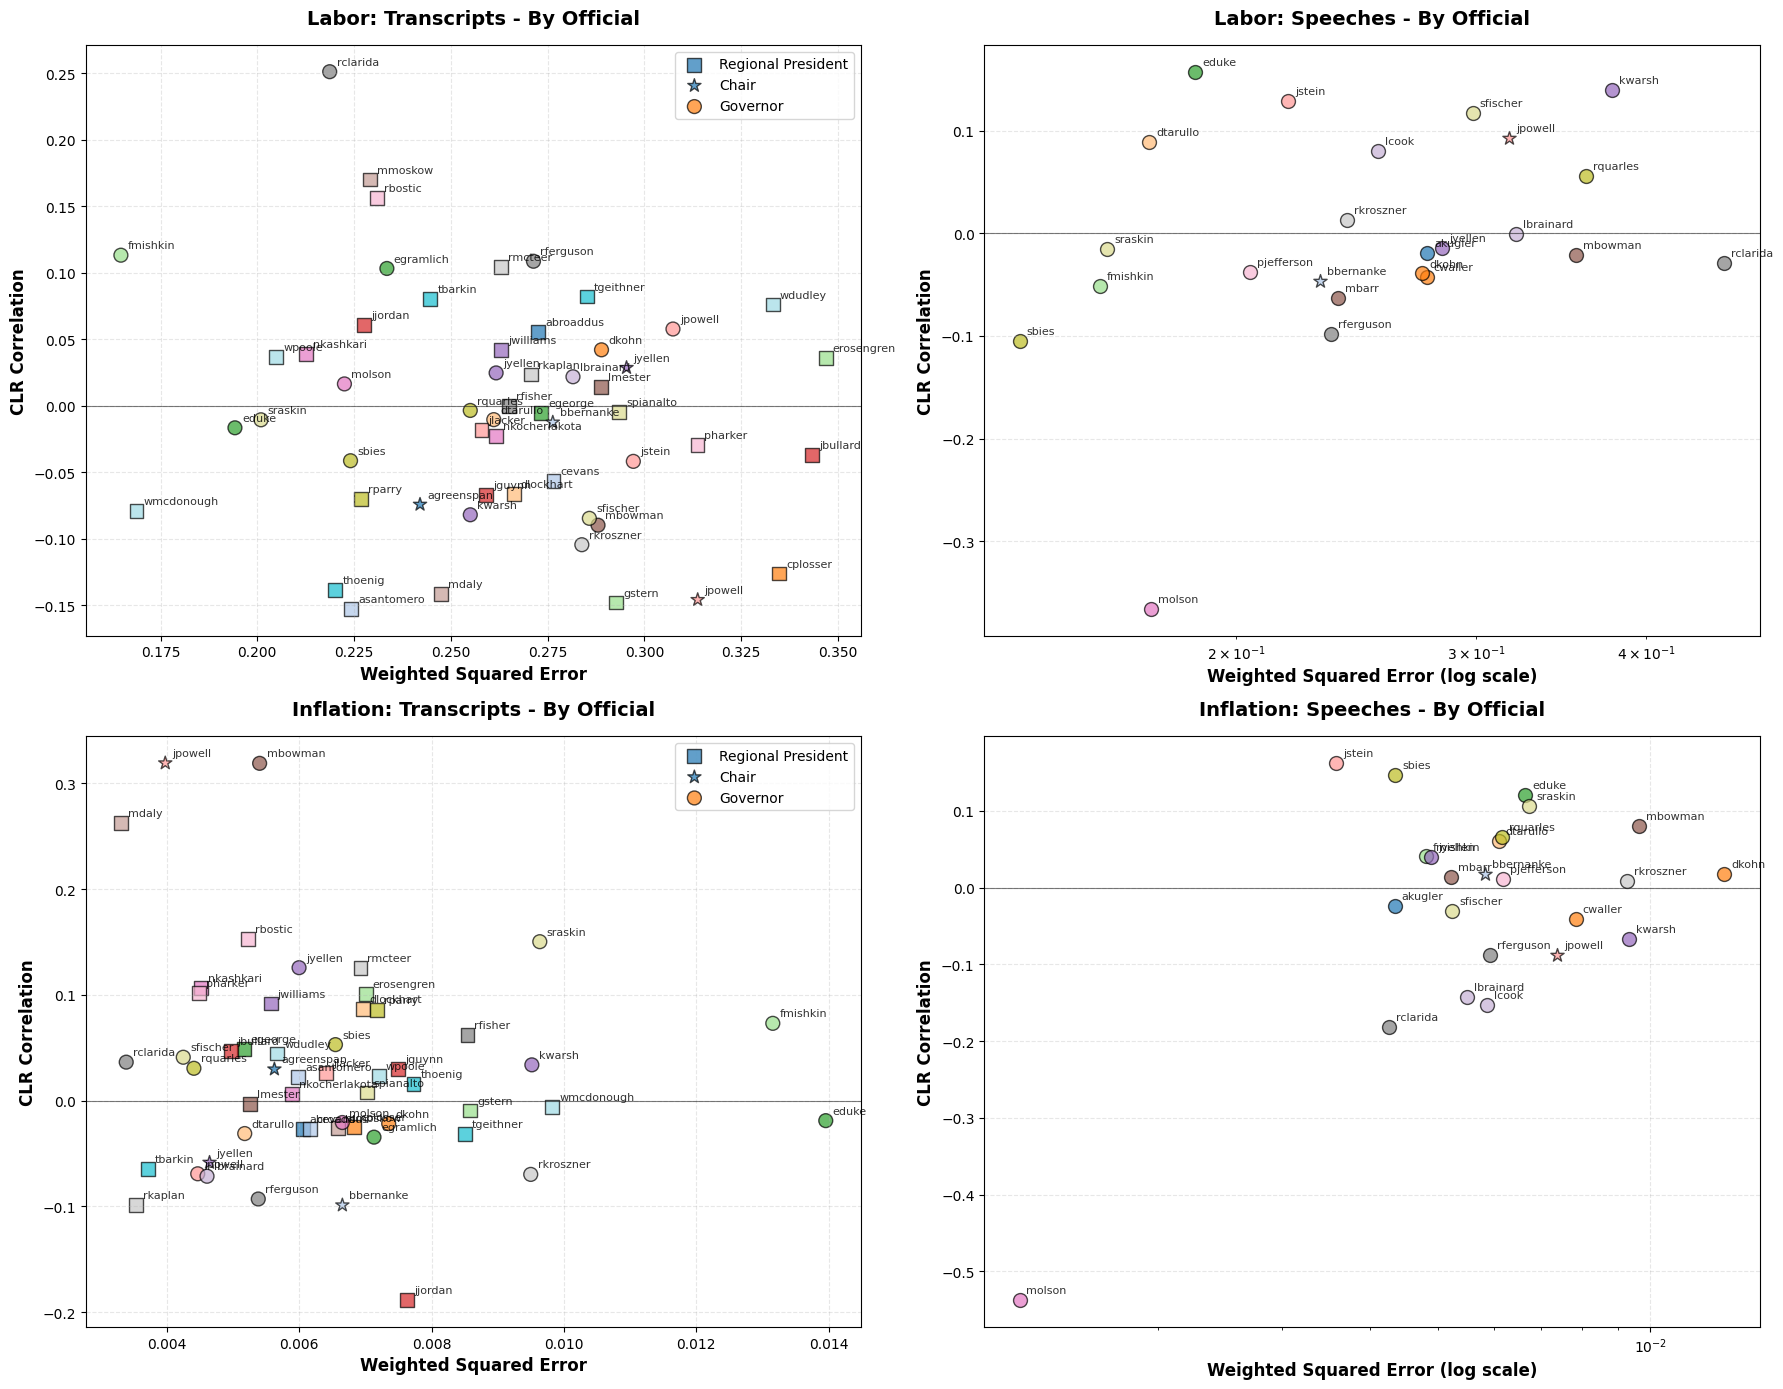


✓ ANALYSIS 2 COMPLETE


In [41]:
# ============================================================================
# CELL 3: ANALYSIS 2 - By Official (Transcripts & Speeches Only)
# ============================================================================

print("="*80)
print("ANALYSIS 2: BY OFFICIAL (TRANSCRIPTS & SPEECHES ONLY)")
print("="*80)

# Filter for transcripts and speeches only
df_ts = df[df['com_type'].isin(['transcripts', 'speeches'])].copy()

print(f"\nFiltered data: {len(df_ts)} rows (transcripts + speeches)")
print(f"Communication types: {df_ts['com_type'].value_counts().to_dict()}")

# Check if speaker/role columns exist
if 'speaker' not in df_ts.columns or 'role' not in df_ts.columns:
    print("\n⚠️  WARNING: 'speaker' and 'role' columns not found in data")
    print("Available columns:", [c for c in df_ts.columns if 'speak' in c.lower() or 'role' in c.lower()])
else:
    print(f"\nUnique speakers: {df_ts['speaker'].nunique()}")
    print("\nRole distribution:")
    print(df_ts['role'].value_counts())

def extract_last_name(speaker_name):
    """Extract last name from speaker name"""
    if pd.isna(speaker_name) or speaker_name == '':
        return 'Unknown'
    name = str(speaker_name)
    upper_indices = [i for i, c in enumerate(name) if c.isupper()]
    if len(upper_indices) > 1:
        return name[upper_indices[1]:]
    else:
        return name

def get_marker_style(role):
    """Get marker style based on role"""
    role_str = str(role).lower()
    if 'chair' in role_str:
        return '*'  # star
    elif 'governor' in role_str:
        return 'o'  # circle
    elif 'president' in role_str or 'regional' in role_str:
        return 's'  # square
    else:
        return '^'  # triangle

# Calculate measures for each official - LABOR
print("\n" + "="*80)
print("CALCULATING MEASURES FOR EACH OFFICIAL - LABOR")
print("="*80)

labor_results = []

for (speaker, role), group in df_ts.groupby(['speaker', 'role']):
    transcripts = group[group['com_type'] == 'transcripts']
    speeches = group[group['com_type'] == 'speeches']

    result = {
        'speaker': speaker,
        'role': role,
        'last_name': extract_last_name(speaker),
        'n_transcripts': len(transcripts),
        'n_speeches': len(speeches)
    }

    # Get emphasis and error columns for labor
    emphasis_cols = [f'labor_emphasis_{ind}' for ind in labor_indicators.keys()
                    if f'labor_emphasis_{ind}' in group.columns]
    error_cols = [labor_indicators[ind] for ind in labor_indicators.keys()
                 if labor_indicators[ind] in group.columns]

    # Calculate for transcripts
    if len(transcripts) > 0:
        result['transcript_wse'] = calculate_weighted_squared_error(emphasis_cols, error_cols, transcripts)
        result['transcript_clr'] = calculate_clr_correlation(emphasis_cols, error_cols, transcripts)
    else:
        result['transcript_wse'] = np.nan
        result['transcript_clr'] = np.nan

    # Calculate for speeches
    if len(speeches) > 0:
        result['speech_wse'] = calculate_weighted_squared_error(emphasis_cols, error_cols, speeches)
        result['speech_clr'] = calculate_clr_correlation(emphasis_cols, error_cols, speeches)
    else:
        result['speech_wse'] = np.nan
        result['speech_clr'] = np.nan

    labor_results.append(result)

labor_officials = pd.DataFrame(labor_results)
print(f"\n✓ Calculated measures for {len(labor_officials)} officials (labor)")
print(labor_officials.head(10))

# Calculate measures for each official - INFLATION
print("\n" + "="*80)
print("CALCULATING MEASURES FOR EACH OFFICIAL - INFLATION")
print("="*80)

inflation_results = []

for (speaker, role), group in df_ts.groupby(['speaker', 'role']):
    transcripts = group[group['com_type'] == 'transcripts']
    speeches = group[group['com_type'] == 'speeches']

    result = {
        'speaker': speaker,
        'role': role,
        'last_name': extract_last_name(speaker),
        'n_transcripts': len(transcripts),
        'n_speeches': len(speeches)
    }

    # Get emphasis and error columns for inflation
    emphasis_cols = [f'inflation_emphasis_{ind}' for ind in inflation_indicators.keys()
                    if f'inflation_emphasis_{ind}' in group.columns]
    error_cols = [inflation_indicators[ind] for ind in inflation_indicators.keys()
                 if inflation_indicators[ind] in group.columns]

    # Calculate for transcripts
    if len(transcripts) > 0:
        result['transcript_wse'] = calculate_weighted_squared_error(emphasis_cols, error_cols, transcripts)
        result['transcript_clr'] = calculate_clr_correlation(emphasis_cols, error_cols, transcripts)
    else:
        result['transcript_wse'] = np.nan
        result['transcript_clr'] = np.nan

    # Calculate for speeches
    if len(speeches) > 0:
        result['speech_wse'] = calculate_weighted_squared_error(emphasis_cols, error_cols, speeches)
        result['speech_clr'] = calculate_clr_correlation(emphasis_cols, error_cols, speeches)
    else:
        result['speech_wse'] = np.nan
        result['speech_clr'] = np.nan

    inflation_results.append(result)

inflation_officials = pd.DataFrame(inflation_results)
print(f"\n✓ Calculated measures for {len(inflation_officials)} officials (inflation)")
print(inflation_officials.head(10))

# NEW: Create consistent color mapping per official (using last_name for sorting)
unique_speakers = sorted(set(labor_officials['speaker'].unique()) | set(inflation_officials['speaker'].unique()))
num_speakers = len(unique_speakers)
speaker_to_color = {}
colors = plt.cm.tab20(np.linspace(0, 1, num_speakers))  # Use tab20 for distinct colors
for i, speaker in enumerate(sorted(unique_speakers, key=extract_last_name)):
    speaker_to_color[speaker] = colors[i]

# CREATE SCATTER PLOTS
print("\n" + "="*80)
print("CREATING SCATTER PLOTS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: Labor - Transcripts
ax = axes[0, 0]
for role in labor_officials['role'].unique():
    data = labor_officials[labor_officials['role'] == role]
    data = data.dropna(subset=['transcript_wse', 'transcript_clr'])
    if len(data) > 0:
        marker = get_marker_style(role)
        colors = [speaker_to_color[row['speaker']] for _, row in data.iterrows()]
        ax.scatter(data['transcript_wse'], data['transcript_clr'],
                   marker=marker, s=100, alpha=0.7,
                   c=colors, edgecolors='black', linewidth=1,
                   label=role)
        for idx, row in data.iterrows():
            ax.annotate(row['last_name'],
                        (row['transcript_wse'], row['transcript_clr']),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.8)

ax.set_xlabel('Weighted Squared Error', fontsize=12, fontweight='bold')
ax.set_ylabel('CLR Correlation', fontsize=12, fontweight='bold')
ax.set_title('Labor: Transcripts - By Official', fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='best', fontsize=10)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

# Plot 2: Labor - Speeches (log x-axis, colored by official)
ax = axes[0, 1]
speech_data = labor_officials.dropna(subset=['speech_wse', 'speech_clr'])
if len(speech_data) > 0:
    for idx, row in speech_data.iterrows():
        marker = get_marker_style(row['role'])
        color = speaker_to_color[row['speaker']]
        ax.scatter(row['speech_wse'], row['speech_clr'],
                   marker=marker, s=100, alpha=0.7,
                   c=[color],
                   edgecolors='black', linewidth=1)
        ax.annotate(row['last_name'],
                    (row['speech_wse'], row['speech_clr']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.8)

ax.set_xlabel('Weighted Squared Error (log scale)', fontsize=12, fontweight='bold')
ax.set_ylabel('CLR Correlation', fontsize=12, fontweight='bold')
ax.set_title('Labor: Speeches - By Official',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xscale('log')
ax.grid(True, alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

# Plot 3: Inflation - Transcripts
ax = axes[1, 0]
for role in inflation_officials['role'].unique():
    data = inflation_officials[inflation_officials['role'] == role]
    data = data.dropna(subset=['transcript_wse', 'transcript_clr'])
    if len(data) > 0:
        marker = get_marker_style(role)
        colors = [speaker_to_color[row['speaker']] for _, row in data.iterrows()]
        ax.scatter(data['transcript_wse'], data['transcript_clr'],
                   marker=marker, s=100, alpha=0.7,
                   c=colors, edgecolors='black', linewidth=1,
                   label=role)
        for idx, row in data.iterrows():
            ax.annotate(row['last_name'],
                        (row['transcript_wse'], row['transcript_clr']),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.8)

ax.set_xlabel('Weighted Squared Error', fontsize=12, fontweight='bold')
ax.set_ylabel('CLR Correlation', fontsize=12, fontweight='bold')
ax.set_title('Inflation: Transcripts - By Official', fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='best', fontsize=10)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

# Plot 4: Inflation - Speeches (log x-axis, colored by official)
ax = axes[1, 1]
speech_data = inflation_officials.dropna(subset=['speech_wse', 'speech_clr'])
if len(speech_data) > 0:
    for idx, row in speech_data.iterrows():
        marker = get_marker_style(row['role'])
        color = speaker_to_color[row['speaker']]
        ax.scatter(row['speech_wse'], row['speech_clr'],
                   marker=marker, s=100, alpha=0.7,
                   c=[color],
                   edgecolors='black', linewidth=1)
        ax.annotate(row['last_name'],
                    (row['speech_wse'], row['speech_clr']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.8)

ax.set_xlabel('Weighted Squared Error (log scale)', fontsize=12, fontweight='bold')
ax.set_ylabel('CLR Correlation', fontsize=12, fontweight='bold')
ax.set_title('Inflation: Speeches - By Official',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xscale('log')
ax.grid(True, alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.savefig('analysis_2_by_official.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: analysis_2_by_official.png")
plt.show()

print("\n✓ ANALYSIS 2 COMPLETE")

ANALYSIS 3: DISPERSION OVER TIME (QUARTERLY)

Total quarters: 99
Date range: 2000-02-02 00:00:00 to 2025-09-23 00:00:00

CALCULATING QUARTERLY MEASURES - LABOR

✓ Calculated measures for 94 quarters (labor)
  quarter  year  n_docs  emphasis_dispersion  error_dispersion  key_error  \
1  2000Q2  2000      30            83.638269          0.000014   0.213497   
3  2000Q4  2000      47            90.048281          0.000642   0.079424   
4  2001Q1  2001      32            86.184668          0.000256   0.201714   
5  2001Q2  2001      32            94.743631          0.004206   0.341811   
7  2001Q4  2001      50            78.618001          0.016453   0.305398   

   min_squared_error  clr_correlation  
1           0.000736         0.108093  
3           0.000374        -0.120553  
4           0.003937        -0.072107  
5           0.002870         0.037522  
7           0.000008        -0.060351  

CALCULATING QUARTERLY MEASURES - INFLATION

✓ Calculated measures for 93 quarters (inflat

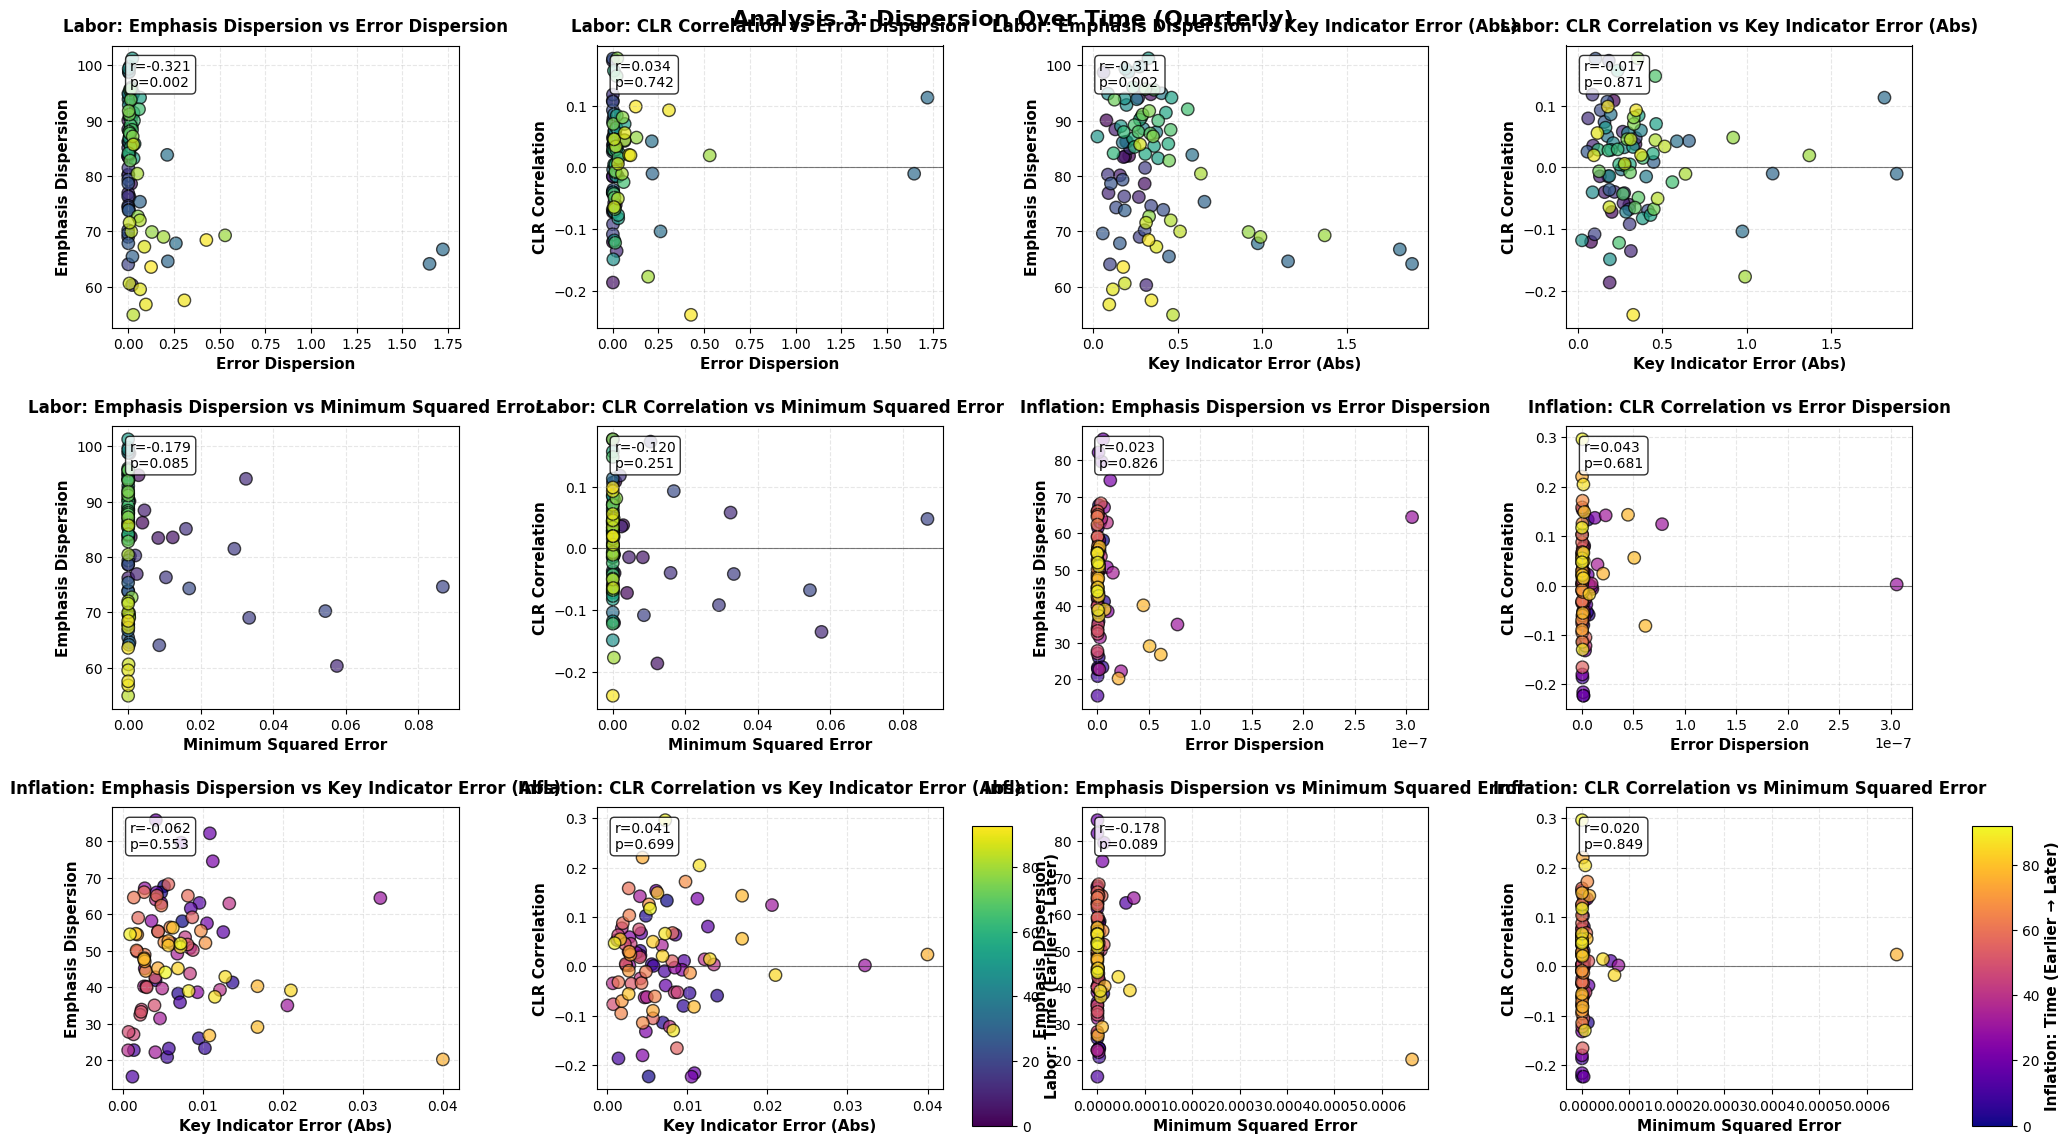


SUMMARY STATISTICS

=== LABOR ===

Correlations with Emphasis Dispersion:
  Error Dispersion              : r=-0.3213, p= 0.0016
  Key Indicator Error (Abs)     : r=-0.3112, p= 0.0023
  Minimum Squared Error         : r=-0.1788, p= 0.0847

Correlations with CLR Correlation:
  Error Dispersion              : r= 0.0344, p= 0.7419
  Key Indicator Error (Abs)     : r=-0.0170, p= 0.8707
  Minimum Squared Error         : r=-0.1197, p= 0.2506

=== INFLATION ===

Correlations with Emphasis Dispersion:
  Error Dispersion              : r= 0.0231, p= 0.8258
  Key Indicator Error (Abs)     : r=-0.0622, p= 0.5534
  Minimum Squared Error         : r=-0.1776, p= 0.0886

Correlations with CLR Correlation:
  Error Dispersion              : r= 0.0432, p= 0.6810
  Key Indicator Error (Abs)     : r= 0.0406, p= 0.6994
  Minimum Squared Error         : r= 0.0201, p= 0.8486

✓ ANALYSIS 3 COMPLETE


In [43]:
# ============================================================================
# CELL 4: ANALYSIS 3 - Dispersion Over Time (Quarterly)
# ============================================================================

print("="*80)
print("ANALYSIS 3: DISPERSION OVER TIME (QUARTERLY)")
print("="*80)


# Create quarter variable
df['quarter'] = df['date'].dt.to_period('Q').astype(str)

print(f"\nTotal quarters: {df['quarter'].nunique()}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

def calculate_emphasis_dispersion_clr(emphasis_cols, data):
    """Calculate emphasis dispersion: variance of CLR-transformed emphasis vectors"""
    dispersions = []
    for _, row in data.iterrows():
        emphasis_values = []
        for col in emphasis_cols:
            if col in row.index and not pd.isna(row[col]):
                emphasis_values.append(row[col])
        if len(emphasis_values) > 1:
            clr_vals = clr_transform(emphasis_values)
            dispersion = np.var(clr_vals)
            dispersions.append(dispersion)
        else:
            dispersions.append(np.nan)
    return dispersions

def calculate_error_dispersion(error_cols, data):
    """Calculate error dispersion: variance of squared errors"""
    dispersions = []
    for _, row in data.iterrows():
        error_values = []
        for col in error_cols:
            if col in row.index and not pd.isna(row[col]):
                error_values.append(row[col]**2)
        if len(error_values) > 1:
            dispersion = np.var(error_values)
            dispersions.append(dispersion)
        else:
            dispersions.append(np.nan)
    return dispersions

# LABOR QUARTERLY ANALYSIS
print("\n" + "="*80)
print("CALCULATING QUARTERLY MEASURES - LABOR")
print("="*80)

labor_emphasis_cols = [f'labor_emphasis_{ind}' for ind in labor_indicators.keys()
                      if f'labor_emphasis_{ind}' in df.columns]
labor_error_cols = [labor_indicators[ind] for ind in labor_indicators.keys()
                   if labor_indicators[ind] in df.columns]

labor_quarterly_results = []

for quarter in sorted(df['quarter'].unique()):
    quarter_data = df[df['quarter'] == quarter].copy()
    if len(quarter_data) == 0:
        continue

    result = {
        'quarter': quarter,
        'year': quarter_data['date'].dt.year.iloc[0],
        'n_docs': len(quarter_data)
    }

    # Calculate emphasis dispersion
    emphasis_dispersions = calculate_emphasis_dispersion_clr(labor_emphasis_cols, quarter_data)
    result['emphasis_dispersion'] = np.nanmean(emphasis_dispersions)

    # Calculate error dispersion
    error_dispersions = calculate_error_dispersion(labor_error_cols, quarter_data)
    result['error_dispersion'] = np.nanmean(error_dispersions)

    # Key indicator error (unemployment)
    if 'error_yU' in quarter_data.columns:
        result['key_error'] = np.nanmean(quarter_data['error_yU'].abs())
    else:
        result['key_error'] = np.nan

    # Minimum squared error
    min_sq_errors = []
    for err_col in labor_error_cols:
        if err_col in quarter_data.columns:
            min_sq_errors.append(np.nanmin(quarter_data[err_col]**2))
    result['min_squared_error'] = min(min_sq_errors) if min_sq_errors else np.nan

    # CLR correlation for the quarter
    clr_corr = calculate_clr_correlation(labor_emphasis_cols, labor_error_cols, quarter_data)
    result['clr_correlation'] = clr_corr

    labor_quarterly_results.append(result)

labor_quarterly = pd.DataFrame(labor_quarterly_results)
labor_quarterly = labor_quarterly.dropna(subset=['emphasis_dispersion', 'clr_correlation'])

print(f"\n✓ Calculated measures for {len(labor_quarterly)} quarters (labor)")
print(labor_quarterly.head())

# INFLATION QUARTERLY ANALYSIS
print("\n" + "="*80)
print("CALCULATING QUARTERLY MEASURES - INFLATION")
print("="*80)

inflation_emphasis_cols = [f'inflation_emphasis_{ind}' for ind in inflation_indicators.keys()
                          if f'inflation_emphasis_{ind}' in df.columns]
inflation_error_cols = [inflation_indicators[ind] for ind in inflation_indicators.keys()
                       if inflation_indicators[ind] in df.columns]

inflation_quarterly_results = []

for quarter in sorted(df['quarter'].unique()):
    quarter_data = df[df['quarter'] == quarter].copy()
    if len(quarter_data) == 0:
        continue

    result = {
        'quarter': quarter,
        'year': quarter_data['date'].dt.year.iloc[0],
        'n_docs': len(quarter_data)
    }

    # Calculate emphasis dispersion
    emphasis_dispersions = calculate_emphasis_dispersion_clr(inflation_emphasis_cols, quarter_data)
    result['emphasis_dispersion'] = np.nanmean(emphasis_dispersions)

    # Calculate error dispersion
    error_dispersions = calculate_error_dispersion(inflation_error_cols, quarter_data)
    result['error_dispersion'] = np.nanmean(error_dispersions)

    # Key indicator error (core inflation)
    if 'error_yCore' in quarter_data.columns:
        result['key_error'] = np.nanmean(quarter_data['error_yCore'].abs())
    else:
        result['key_error'] = np.nan

    # Minimum squared error
    min_sq_errors = []
    for err_col in inflation_error_cols:
        if err_col in quarter_data.columns:
            min_sq_errors.append(np.nanmin(quarter_data[err_col]**2))
    result['min_squared_error'] = min(min_sq_errors) if min_sq_errors else np.nan

    # CLR correlation for the quarter
    clr_corr = calculate_clr_correlation(inflation_emphasis_cols, inflation_error_cols, quarter_data)
    result['clr_correlation'] = clr_corr

    inflation_quarterly_results.append(result)

inflation_quarterly = pd.DataFrame(inflation_quarterly_results)
inflation_quarterly = inflation_quarterly.dropna(subset=['emphasis_dispersion', 'clr_correlation'])

print(f"\n✓ Calculated measures for {len(inflation_quarterly)} quarters (inflation)")
print(inflation_quarterly.head())

# CREATE VISUALIZATIONS
print("\n" + "="*80)
print("CREATING SCATTER PLOTS WITH CHRONOLOGICAL COLOR SHADING")
print("="*80)

fig = plt.figure(figsize=(20, 12))

# Create chronological indices for color mapping
labor_quarterly['chrono_index'] = range(len(labor_quarterly))
inflation_quarterly['chrono_index'] = range(len(inflation_quarterly))

labor_norm = plt.Normalize(vmin=0, vmax=len(labor_quarterly)-1)
inflation_norm = plt.Normalize(vmin=0, vmax=len(inflation_quarterly)-1)

tests = [
    ('error_dispersion', 'Error Dispersion'),
    ('key_error', 'Key Indicator Error (Abs)'),
    ('min_squared_error', 'Minimum Squared Error')
]

plot_num = 1

# LABOR PLOTS
for i, (x_var, x_label) in enumerate(tests):
    # Emphasis Dispersion vs X
    ax = plt.subplot(3, 4, plot_num)
    data = labor_quarterly.dropna(subset=[x_var, 'emphasis_dispersion'])
    scatter = ax.scatter(data[x_var], data['emphasis_dispersion'],
                        c=data['chrono_index'], cmap='viridis',
                        s=80, alpha=0.7, edgecolors='black', linewidth=1)
    ax.set_xlabel(x_label, fontsize=11, fontweight='bold')
    ax.set_ylabel('Emphasis Dispersion', fontsize=11, fontweight='bold')
    ax.set_title(f'Labor: Emphasis Dispersion vs {x_label}',
                fontsize=12, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    if len(data) > 2:
        corr, pval = pearsonr(data[x_var], data['emphasis_dispersion'])
        ax.text(0.05, 0.95, f'r={corr:.3f}\np={pval:.3f}',
               transform=ax.transAxes, fontsize=10,
               verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plot_num += 1

    # CLR Correlation vs X
    ax = plt.subplot(3, 4, plot_num)
    data = labor_quarterly.dropna(subset=[x_var, 'clr_correlation'])
    scatter = ax.scatter(data[x_var], data['clr_correlation'],
                        c=data['chrono_index'], cmap='viridis',
                        s=80, alpha=0.7, edgecolors='black', linewidth=1)
    ax.set_xlabel(x_label, fontsize=11, fontweight='bold')
    ax.set_ylabel('CLR Correlation', fontsize=11, fontweight='bold')
    ax.set_title(f'Labor: CLR Correlation vs {x_label}',
                fontsize=12, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
    if len(data) > 2:
        corr, pval = pearsonr(data[x_var], data['clr_correlation'])
        ax.text(0.05, 0.95, f'r={corr:.3f}\np={pval:.3f}',
               transform=ax.transAxes, fontsize=10,
               verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plot_num += 1

# INFLATION PLOTS
for i, (x_var, x_label) in enumerate(tests):
    # Emphasis Dispersion vs X
    ax = plt.subplot(3, 4, plot_num)
    data = inflation_quarterly.dropna(subset=[x_var, 'emphasis_dispersion'])
    scatter = ax.scatter(data[x_var], data['emphasis_dispersion'],
                        c=data['chrono_index'], cmap='plasma',
                        s=80, alpha=0.7, edgecolors='black', linewidth=1)
    ax.set_xlabel(x_label, fontsize=11, fontweight='bold')
    ax.set_ylabel('Emphasis Dispersion', fontsize=11, fontweight='bold')
    ax.set_title(f'Inflation: Emphasis Dispersion vs {x_label}',
                fontsize=12, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    if len(data) > 2:
        corr, pval = pearsonr(data[x_var], data['emphasis_dispersion'])
        ax.text(0.05, 0.95, f'r={corr:.3f}\np={pval:.3f}',
               transform=ax.transAxes, fontsize=10,
               verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plot_num += 1

    # CLR Correlation vs X
    ax = plt.subplot(3, 4, plot_num)
    data = inflation_quarterly.dropna(subset=[x_var, 'clr_correlation'])
    scatter = ax.scatter(data[x_var], data['clr_correlation'],
                        c=data['chrono_index'], cmap='plasma',
                        s=80, alpha=0.7, edgecolors='black', linewidth=1)
    ax.set_xlabel(x_label, fontsize=11, fontweight='bold')
    ax.set_ylabel('CLR Correlation', fontsize=11, fontweight='bold')
    ax.set_title(f'Inflation: CLR Correlation vs {x_label}',
                fontsize=12, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
    if len(data) > 2:
        corr, pval = pearsonr(data[x_var], data['clr_correlation'])
        ax.text(0.05, 0.95, f'r={corr:.3f}\np={pval:.3f}',
               transform=ax.transAxes, fontsize=10,
               verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plot_num += 1

# Add colorbars
cax1 = fig.add_axes([0.48, 0.05, 0.02, 0.25])
sm1 = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=labor_norm)
sm1.set_array([])
cbar1 = plt.colorbar(sm1, cax=cax1)
cbar1.set_label('Labor: Time (Earlier → Later)', fontsize=11, fontweight='bold')

cax2 = fig.add_axes([0.98, 0.05, 0.02, 0.25])
sm2 = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=inflation_norm)
sm2.set_array([])
cbar2 = plt.colorbar(sm2, cax=cax2)
cbar2.set_label('Inflation: Time (Earlier → Later)', fontsize=11, fontweight='bold')

plt.suptitle('Analysis 3: Dispersion Over Time (Quarterly)',
            fontsize=16, fontweight='bold', y=0.98)
plt.subplots_adjust(hspace=0.35, wspace=0.4, bottom=0.08, top=0.95, left=0.05, right=0.95)

plt.savefig('analysis_3_dispersion_over_time.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: analysis_3_dispersion_over_time.png")
plt.show()

# SUMMARY STATISTICS
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

print("\n=== LABOR ===")
print("\nCorrelations with Emphasis Dispersion:")
for x_var, x_label in tests:
    data = labor_quarterly.dropna(subset=[x_var, 'emphasis_dispersion'])
    if len(data) > 2:
        corr, pval = pearsonr(data[x_var], data['emphasis_dispersion'])
        print(f"  {x_label:<30}: r={corr:>7.4f}, p={pval:>7.4f}")

print("\nCorrelations with CLR Correlation:")
for x_var, x_label in tests:
    data = labor_quarterly.dropna(subset=[x_var, 'clr_correlation'])
    if len(data) > 2:
        corr, pval = pearsonr(data[x_var], data['clr_correlation'])
        print(f"  {x_label:<30}: r={corr:>7.4f}, p={pval:>7.4f}")

print("\n=== INFLATION ===")
print("\nCorrelations with Emphasis Dispersion:")
for x_var, x_label in tests:
    data = inflation_quarterly.dropna(subset=[x_var, 'emphasis_dispersion'])
    if len(data) > 2:
        corr, pval = pearsonr(data[x_var], data['emphasis_dispersion'])
        print(f"  {x_label:<30}: r={corr:>7.4f}, p={pval:>7.4f}")

print("\nCorrelations with CLR Correlation:")
for x_var, x_label in tests:
    data = inflation_quarterly.dropna(subset=[x_var, 'clr_correlation'])
    if len(data) > 2:
        corr, pval = pearsonr(data[x_var], data['clr_correlation'])
        print(f"  {x_label:<30}: r={corr:>7.4f}, p={pval:>7.4f}")

print("\n✓ ANALYSIS 3 COMPLETE")